In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from tqdm.auto import tqdm

# Подготовка датасета

In [2]:
#импортируем датасет

df = pd.read_csv('wiki_movie_plots_deduped.csv', sep=',')

In [3]:
df.head(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [4]:
#приводим к нижнему регистру

df['Genre_1'] = df['Genre'].str.lower()
df['Plot'] = df['Plot'].str.lower()

In [5]:
# количество фильмов по жанрам
df['Genre_1'].value_counts()

unknown                          6083
drama                            5964
comedy                           4379
horror                           1167
action                           1098
                                 ... 
cbc-tv miniseries                   1
bio-drama                           1
national film board docudrama       1
cult drama                          1
horror romantic comedy              1
Name: Genre_1, Length: 2265, dtype: int64

In [6]:
# в датасете 2265 жанров, необходимо преобразовать данные для предсказания жанров
# тестирую на копии df

df_copy = df.copy()

In [7]:
#преобразуем данные,чтобы разбить жанры по словам

df_copy['Genre_2']=df_copy['Genre_1'].str.replace(',', '/')
df_copy['Genre_2']=df_copy['Genre_2'].str.replace(' / ', '/')
df_copy['Genre_2']=df_copy['Genre_2'].str.replace('/ ', '/')
df_copy['Genre_2']=df_copy['Genre_2'].str.replace(' /', '/')
df_copy['Genre_2']=df_copy['Genre_2'].str.replace(' ', '/')
df_copy['Genre_2']=df_copy['Genre_2'].str.replace('/&/', '/')
df_copy['Genre_2']=df_copy['Genre_2'].str.replace('/-/', '/')
df_copy['Genre_2']=df_copy['Genre_2'].str.replace('sci-fi', 'sci_fi')
df_copy['Genre_2']=df_copy['Genre_2'].str.replace('bio-pic', 'biopic')
df_copy['Genre_2']=df_copy['Genre_2'].str.replace('-', '/')

In [8]:
df_copy.sample(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Genre_1,Genre_2
11892,1992,Shining Through,American,David Seltzer,"Michael Douglas, Melanie Griffith, Liam Neeson...",drama,https://en.wikipedia.org/wiki/Shining_Through,"in 1940, linda voss (melanie griffith), a youn...",drama,drama
11338,1990,"After Dark, My Sweet",American,James Foley,"Jason Patric, Rachel Ward, Bruce Dern",mystery,"https://en.wikipedia.org/wiki/After_Dark,_My_S...","ex-boxer kevin ""kid"" collins is a drifter and ...",mystery,mystery
28771,2015,Mahanayak Vasant Tu,Marathi,Nilesh Jalamkar,"Chinmay Mandalekar, Nisha Parulekar, Bharat Ga...","biopic, drama",https://en.wikipedia.org/wiki/Mahanayak_vasant_tu,mahanayak vasnat tu showcases the life of shre...,"biopic, drama",biopic/drama
22928,1958,Al-Tareeq al-Masdood (The Barred Road),Egyptian,Salah Abouseif,"Faten Hamama, Ahmed Mazhar, Shukry Sarhan",drama,https://en.wikipedia.org/wiki/Al-Tareeq_al-Mas...,"faten hamama plays fayza, a young student who ...",drama,drama
34321,1963,Rice,South_Korean,Shin Sang-ok,NaN,unknown,https://en.wikipedia.org/wiki/Rice_(1963_film),"the farmers of muju, cheonbuk province, are no...",unknown,unknown


In [9]:
# создаем df жанрами, разделенными по столбцам
new_df = df_copy['Genre_2'].str.split('/', expand=True)
new_df.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12
5804,comedy,None,None,None,None,None,None,None,None,None,None,None,None
34037,unknown,None,None,None,None,None,None,None,None,None,None,None,None
22690,drama,comedy,None,None,None,None,None,None,None,None,None,None,None
17971,unknown,None,None,None,None,None,None,None,None,None,None,None,None
5204,film,noir,None,None,None,None,None,None,None,None,None,None,None


In [11]:
#new_df.to_excel('new_df.xlsx')

In [10]:
#добавляем первое слово жанра к df_copy (при перечислении жанров обычно основной указывается вначале)
df_copy['Genre_1st_word']=new_df[0]

In [11]:
#создадим словарь для обработки df_copy['Origin/Ethnicity']

dict_orig ={
    'American': 'American', 'British': 'British', 'Bollywood': 'Indian', 
    'Tamil': 'Indian', 'Telugu': 'Indian', 'Japanese': 'Asian', 'Malayalam': 'Indian',
    'Hong Kong': 'Asian', 'Canadian': 'Canadian', 'Australian': 'Australian', 'South_Korean': 'Asian',
    'Chinese': 'Asian', 'Kannada': 'Indian', 'Bengali': 'Indian', 'Russian': 'Russian', 'Marathi': 'Indian',
    'Filipino': 'Asian', 'Bangladeshi': 'Asian', 'Punjabi': 'Indian', 'Malaysian': 'Asian', 'Turkish':'Turkish',
    'Egyptian': 'Egyptian', 'Assamese': 'Indian', 'Maldivian': 'Asian'
}

In [12]:
#добавим в df_copy столбец с регионом происхождения
df_copy['Origin'] = df_copy['Origin/Ethnicity'].map(dict_orig)

In [13]:
# произведем некоторые замены в df_copy['Genre_1st_word']
df_copy['Genre_1st_word']=df_copy['Genre_1st_word'].str.replace('film', 'film_noir')
df_copy['Genre_1st_word']=df_copy['Genre_1st_word'].str.replace('romantic', 'romance')
df_copy['Genre_1st_word']=df_copy['Genre_1st_word'].str.replace('animation', 'animated')

In [14]:
#добавим столбец с количеством фильмов по жаннру
df_copy['n_films_by_genre']= df_copy.Genre_1st_word.map(df_copy['Genre_1st_word'].value_counts())

In [15]:
#приводим к нижнему регистру df_copy['Plot']
df_copy['Plot'] = df_copy['Plot'].str.lower()

In [16]:
#удаляем знаки препинания
df_copy['Plot'] = df['Plot'].str.replace('[^\w\s]','')

C:\Users\User\AppData\Local\Temp\ipykernel_11632\3468545993.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_copy['Plot'] = df['Plot'].str.replace('[^\w\s]','')


In [17]:
df_copy['Plot']

0        a bartender is working at a saloon serving dri...
1        the moon painted with a smiling face hangs ove...
2        the film just over a minute long is composed o...
3        lasting just 61 seconds and consisting of two ...
4        the earliest known adaptation of the classic f...
                               ...                        
34881    the film begins in 1919 just after world war i...
34882    two musicians salih and gürkan described the a...
34883    zafer a sailor living with his mother döndü in...
34884    the film centres around a young woman named am...
34885    the writer orhan şahin returns to istanbul aft...
Name: Plot, Length: 34886, dtype: object

In [18]:
#жанров после обработки осталось 334
df_copy['Genre_1st_word'].value_counts()

drama            6888
unknown          6083
comedy           5638
action           2072
romance          1944
                 ... 
physiological       1
romance;            1
tapas               1
outlaw              1
travel              1
Name: Genre_1st_word, Length: 334, dtype: int64

In [19]:
# модели будем строить на df_copy3, попробуем обработать срез df с количсетвом жанров > 400
df_copy3 = df_copy[df_copy['n_films_by_genre'] > 400]

In [20]:
#удалим 'unknown' жанр
df_copy3 = df_copy3[df_copy3['Genre_1st_word'] != 'unknown']

In [21]:
df_copy3.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot', 'Genre_1', 'Genre_2', 'Genre_1st_word',
       'Origin', 'n_films_by_genre'],
      dtype='object')

In [22]:
#удалим ненужные колонки
#df_copy3 = df_copy3.drop(['Release Year', 'Origin/Ethnicity',
                              'Director', 'Cast', 'Wiki Page',
                              'Genre_1', 'Genre_2', 'n_films_by_genre'
                             ], axis=1)

In [21]:
#проверим
#df_copy3.columns

Index(['Release Year', 'Title', 'Origin/Ethnicity', 'Director', 'Cast',
       'Genre', 'Wiki Page', 'Plot', 'Genre_1', 'Genre_2', 'Genre_1st_word',
       'Origin', 'n_films_by_genre'],
      dtype='object')

In [22]:
df_copy3['Genre_1st_word'].value_counts()

drama        6888
comedy       5638
action       2072
romance      1944
horror       1391
crime        1278
thriller     1061
western       924
animated      714
musical       708
adventure     610
science       495
war           408
family        402
Name: Genre_1st_word, dtype: int64

In [24]:
df_copy3['Origin'].value_counts()

American      14814
Indian         4507
British        2539
Asian          1479
Canadian        555
Australian      394
Russian         124
Egyptian         63
Turkish          58
Name: Origin, dtype: int64

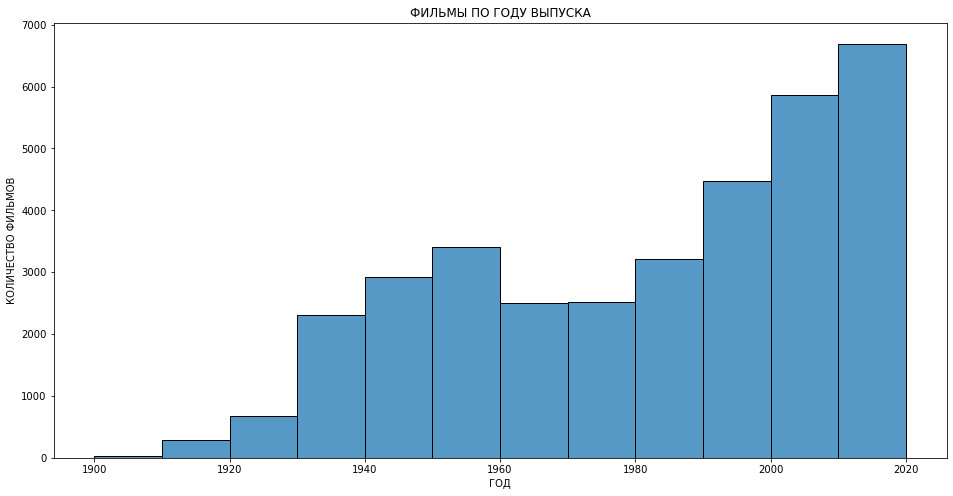

In [26]:
fig, ax = plt.subplots(figsize=(16,8))

sns.histplot(x = df_copy['Release Year'], bins=[1900, 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020])
plt.title('ФИЛЬМЫ ПО ГОДУ ВЫПУСКА')
plt.xlabel('ГОД')
plt.ylabel('КОЛИЧЕСТВО ФИЛЬМОВ')
fig.savefig('hist1.png');

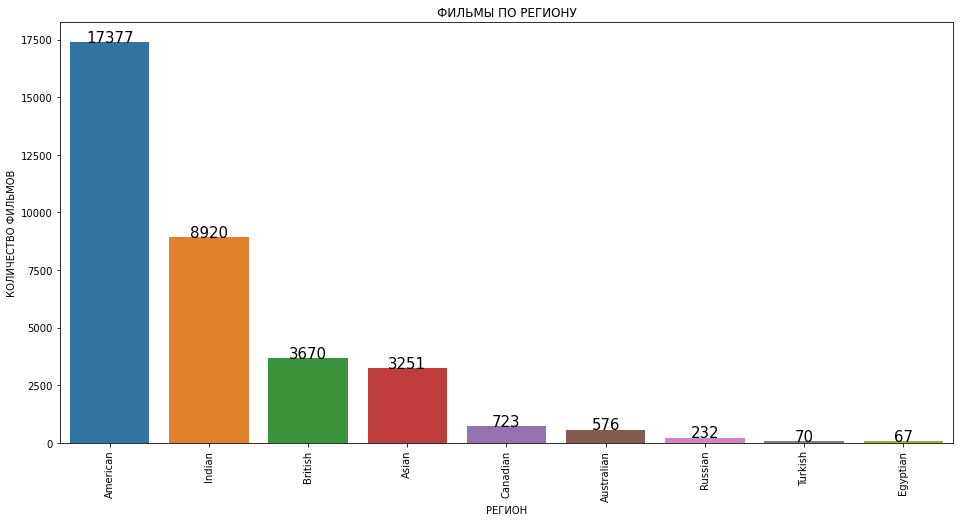

In [27]:
fig, ax = plt.subplots(figsize=(16,8))

sns.countplot(x = df_copy['Origin'],  order = df_copy['Origin'].value_counts().index)
plt.gcf().subplots_adjust(bottom=0.15)
plt.xticks(rotation = 90)
plt.title('ФИЛЬМЫ ПО РЕГИОНУ')
plt.xlabel('РЕГИОН')
plt.ylabel('КОЛИЧЕСТВО ФИЛЬМОВ')
fig.savefig('hist2.png');

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 15)


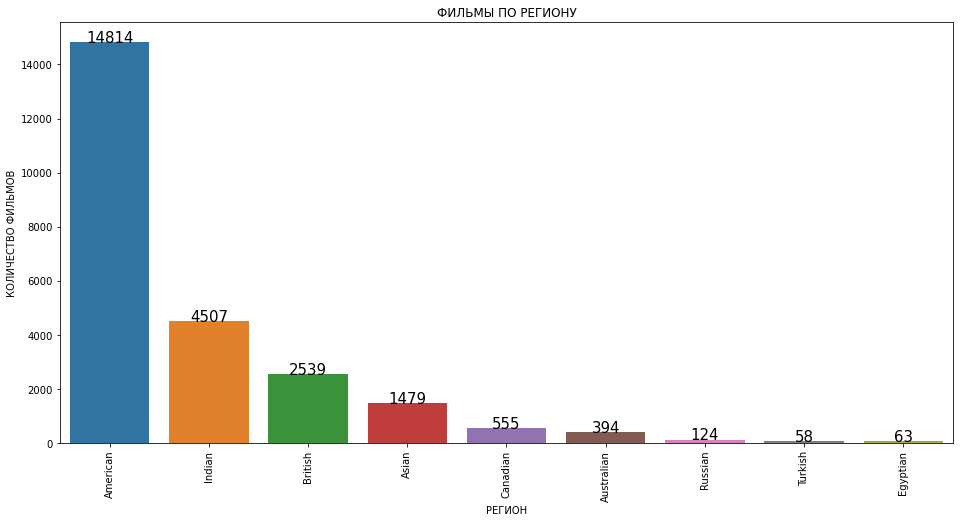

In [28]:
# гистограмма по регионам, но без жанра 'unknown'

fig, ax = plt.subplots(figsize=(16,8))

sns.countplot(x = df_copy3['Origin'],  order = df_copy['Origin'].value_counts().index)
plt.gcf().subplots_adjust(bottom=0.15)
plt.xticks(rotation = 90)
plt.title('ФИЛЬМЫ ПО РЕГИОНУ')
plt.xlabel('РЕГИОН')
plt.ylabel('КОЛИЧЕСТВО ФИЛЬМОВ')
fig.savefig('hist3.png');

for rect in ax.patches:
    ax.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+ 0.75,rect.get_height(),horizontalalignment='center', fontsize = 15)


In [29]:
df_copy3[df_copy3['Origin']=='American']['Genre_1st_word']

6        western
7         comedy
14        comedy
15        comedy
16         drama
          ...   
17369     comedy
17371     action
17372      crime
17373    western
17376      drama
Name: Genre_1st_word, Length: 14814, dtype: object

In [30]:
genre_order = ['drama', 'comedy', 'action', 'romance', 'horror', 'crime', 
               'thriller', 'western', 'animated', 'musical', 'adventure', 'science', 'war', 'family']

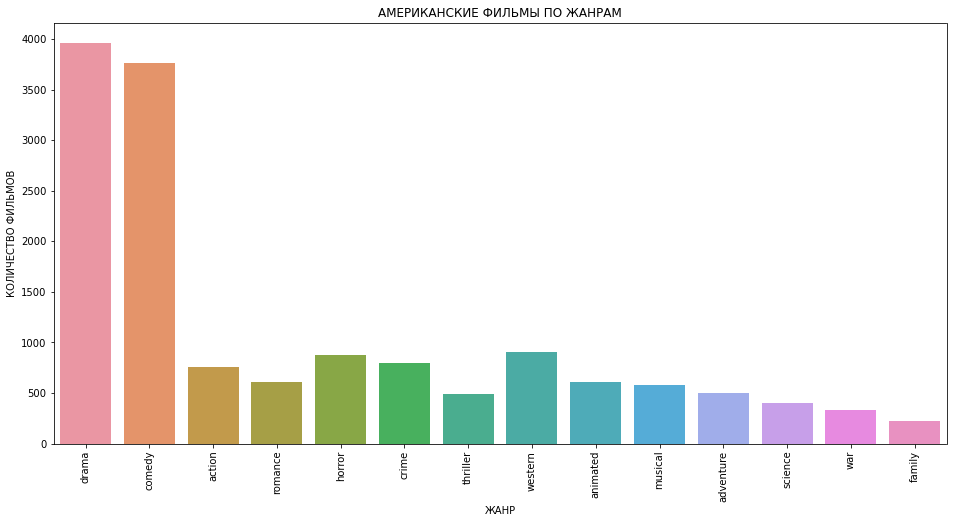

In [31]:
fig, ax = plt.subplots(figsize=(16,8))

sns.countplot(x = df_copy3[df_copy3['Origin']=='American']['Genre_1st_word'], order = genre_order)
plt.gcf().subplots_adjust(bottom=0.15)
plt.xticks(rotation = 90)
plt.title('АМЕРИКАНСКИЕ ФИЛЬМЫ ПО ЖАНРАМ')
plt.xlabel('ЖАНР')
plt.ylabel('КОЛИЧЕСТВО ФИЛЬМОВ')
fig.savefig('hist4.png');

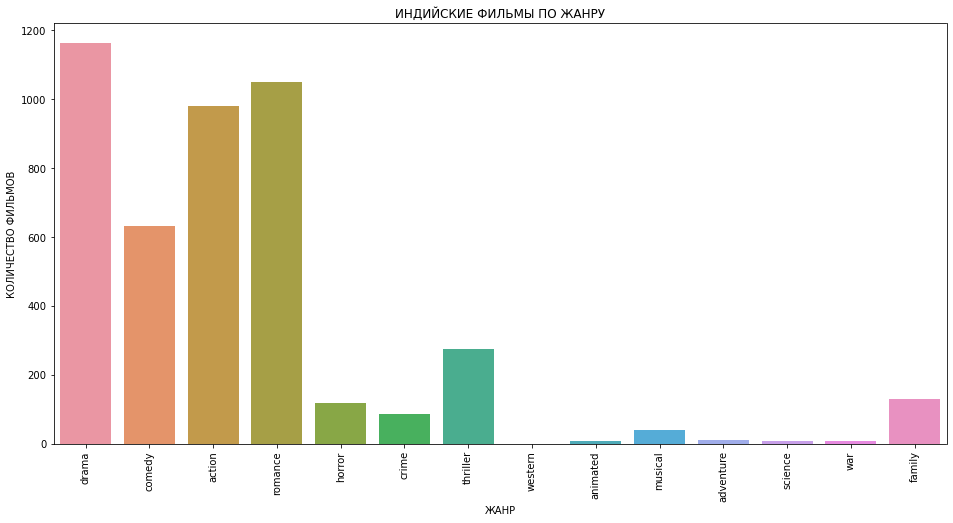

In [32]:
fig, ax = plt.subplots(figsize=(16,8))

sns.countplot(x = df_copy3[df_copy3['Origin']=='Indian']['Genre_1st_word'], order = genre_order)
plt.gcf().subplots_adjust(bottom=0.15)
plt.xticks(rotation = 90)
plt.title('ИНДИЙСКИЕ ФИЛЬМЫ ПО ЖАНРУ')
plt.xlabel('ЖАНР')
plt.ylabel('КОЛИЧЕСТВО ФИЛЬМОВ')
fig.savefig('hist5.png');

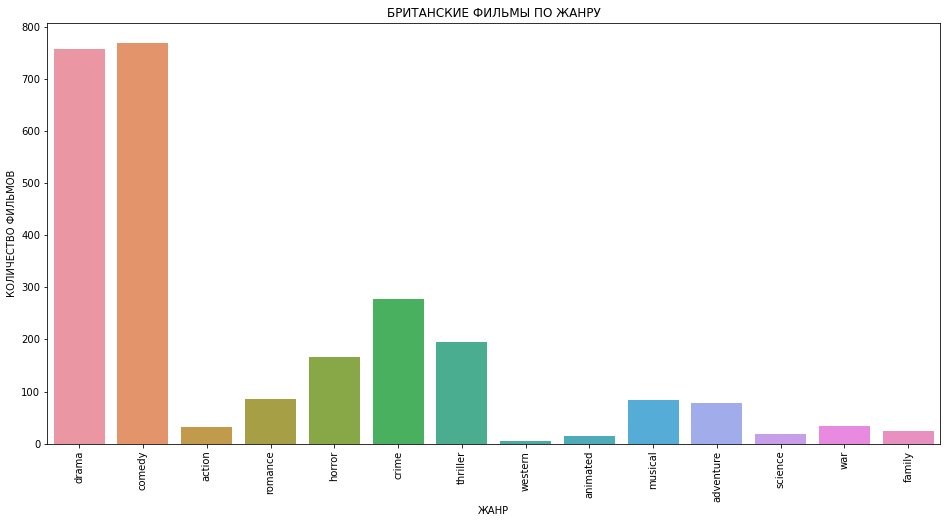

In [33]:
fig, ax = plt.subplots(figsize=(16,8))

sns.countplot(x = df_copy3[df_copy3['Origin']=='British']['Genre_1st_word'], order = genre_order)
plt.gcf().subplots_adjust(bottom=0.15)
plt.xticks(rotation = 90)
plt.title('БРИТАНСКИЕ ФИЛЬМЫ ПО ЖАНРУ')
plt.xlabel('ЖАНР')
plt.ylabel('КОЛИЧЕСТВО ФИЛЬМОВ')
fig.savefig('hist6.png');

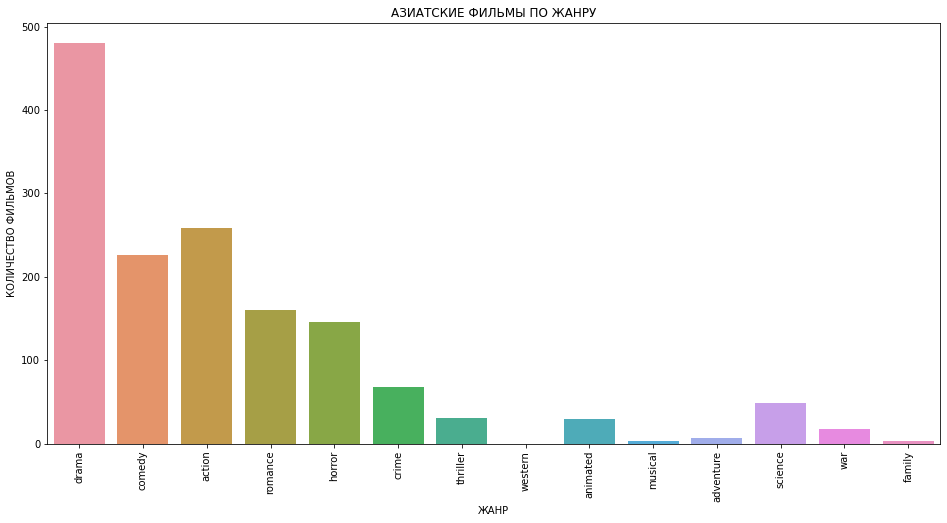

In [34]:
fig, ax = plt.subplots(figsize=(16,8))

sns.countplot(x = df_copy3[df_copy3['Origin']=='Asian']['Genre_1st_word'], order = genre_order)
plt.gcf().subplots_adjust(bottom=0.15)
plt.xticks(rotation = 90)
plt.title('АЗИАТСКИЕ ФИЛЬМЫ ПО ЖАНРУ')
plt.xlabel('ЖАНР')
plt.ylabel('КОЛИЧЕСТВО ФИЛЬМОВ')
fig.savefig('hist7.png');

In [35]:
# создадим df для анализа популярных регионов
top_regs = ['American', 'Indian', 'British', 'Asian']
df_copy3_top_regs = df_copy3.loc[df_copy3['Origin'].isin(top_regs)] 

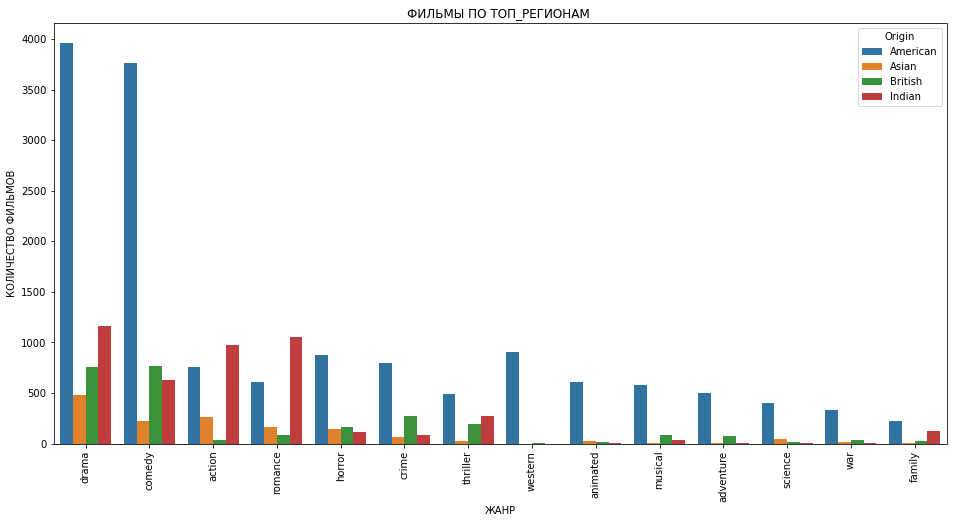

In [36]:
fig, ax = plt.subplots(figsize=(16,8))

sns.countplot(x = df_copy3_top_regs['Genre_1st_word'], hue = df_copy3_top_regs['Origin'], order = genre_order)
plt.gcf().subplots_adjust(bottom=0.15)
plt.xticks(rotation = 90)
plt.title('ФИЛЬМЫ ПО ТОП_РЕГИОНАМ ')
plt.xlabel('ЖАНР')
plt.ylabel('КОЛИЧЕСТВО ФИЛЬМОВ')
fig.savefig('hist8.png');

In [37]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [38]:
#исключим стоп-слова
df_copy3_top_regs['Plot_no_stopwords'] = df_copy3_top_regs['Plot'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

C:\Users\User\AppData\Local\Temp\ipykernel_11632\408903326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy3_top_regs['Plot_no_stopwords'] = df_copy3_top_regs['Plot'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [39]:
#Топ чарт слов в сюжете (Plot)
from collections import Counter
Counter(" ".join(df_copy3_top_regs['Plot_no_stopwords']).split()).most_common(50)

[('one', 19703),
 ('back', 15947),
 ('tells', 14171),
 ('two', 13946),
 ('father', 13317),
 ('love', 12856),
 ('home', 12381),
 ('new', 12344),
 ('get', 12046),
 ('later', 11753),
 ('also', 11632),
 ('house', 11625),
 ('man', 11346),
 ('police', 11282),
 ('time', 11199),
 ('finds', 10964),
 ('family', 10848),
 ('life', 10714),
 ('find', 10416),
 ('however', 10148),
 ('goes', 9956),
 ('day', 9672),
 ('takes', 9651),
 ('go', 9405),
 ('take', 8996),
 ('away', 8930),
 ('mother', 8906),
 ('help', 8801),
 ('money', 8731),
 ('wife', 8730),
 ('gets', 8694),
 ('film', 8561),
 ('tries', 8515),
 ('night', 8247),
 ('son', 7896),
 ('killed', 7747),
 ('first', 7676),
 ('friend', 7646),
 ('men', 7562),
 ('next', 7409),
 ('car', 7384),
 ('young', 7294),
 ('death', 7227),
 ('decides', 7096),
 ('friends', 7017),
 ('leaves', 6983),
 ('daughter', 6950),
 ('becomes', 6941),
 ('leave', 6940),
 ('comes', 6903)]

In [40]:
from nltk.stem.wordnet import WordNetLemmatizer

In [41]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from nltk.stem import WordNetLemmatizer

In [42]:
#проведем токенизацию
df_copy3_top_regs['word_tokens'] = df_copy3_top_regs.apply(lambda row: nltk.word_tokenize(row['Plot_no_stopwords']), axis=1)

C:\Users\User\AppData\Local\Temp\ipykernel_11632\3893461840.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy3_top_regs['word_tokens'] = df_copy3_top_regs.apply(lambda row: nltk.word_tokenize(row['Plot_no_stopwords']), axis=1)


In [43]:
df_copy3_top_regs['word_tokens']

6        [film, opens, two, bandits, breaking, railroad...
7        [film, family, move, suburbs, hoping, quiet, l...
14       [heading, baseball, game, nearby, ballpark, sp...
15       [plot, black, woman, going, dentist, toothache...
16       [beautiful, summer, day, father, mother, take,...
                               ...                        
34524    [tae, gunho, jung, jaeyoung, best, debt, colle...
34525    [wedding, anniversary, han, chulmin, jang, hyu...
34526    [arts, professor, jung, jiwoo, kim, sanghyun, ...
34528    [film, centers, around, young, ambitious, woma...
34529    [jogoo, street, magician, lee, minki, notices,...
Name: word_tokens, Length: 23339, dtype: object

In [44]:
#проведем лемматизацию
lmtzr = WordNetLemmatizer()
df_copy3_top_regs['lemmatize'] = df_copy3_top_regs['word_tokens'].apply(
                    lambda lst:[lmtzr.lemmatize(word) for word in lst])

C:\Users\User\AppData\Local\Temp\ipykernel_11632\2019470857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy3_top_regs['lemmatize'] = df_copy3_top_regs['word_tokens'].apply(


In [45]:
df_copy3_top_regs['lemmatize']

6        [film, open, two, bandit, breaking, railroad, ...
7        [film, family, move, suburb, hoping, quiet, li...
14       [heading, baseball, game, nearby, ballpark, sp...
15       [plot, black, woman, going, dentist, toothache...
16       [beautiful, summer, day, father, mother, take,...
                               ...                        
34524    [tae, gunho, jung, jaeyoung, best, debt, colle...
34525    [wedding, anniversary, han, chulmin, jang, hyu...
34526    [art, professor, jung, jiwoo, kim, sanghyun, s...
34528    [film, center, around, young, ambitious, woman...
34529    [jogoo, street, magician, lee, minki, notice, ...
Name: lemmatize, Length: 23339, dtype: object

In [46]:
#соберем обработанную версию Plot
df_copy3_top_regs['Plot_2'] = df_copy3_top_regs['lemmatize'].apply(lambda x : " ".join(x))

C:\Users\User\AppData\Local\Temp\ipykernel_11632\1083063548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy3_top_regs['Plot_2'] = df_copy3_top_regs['lemmatize'].apply(lambda x : " ".join(x))


In [47]:
df_copy3_top_regs['Plot_2']

6        film open two bandit breaking railroad telegra...
7        film family move suburb hoping quiet life thin...
14       heading baseball game nearby ballpark sport fa...
15       plot black woman going dentist toothache given...
16       beautiful summer day father mother take daught...
                               ...                        
34524    tae gunho jung jaeyoung best debt collection a...
34525    wedding anniversary han chulmin jang hyuk driv...
34526    art professor jung jiwoo kim sanghyun searchin...
34528    film center around young ambitious woman named...
34529    jogoo street magician lee minki notice miserab...
Name: Plot_2, Length: 23339, dtype: object

In [48]:
#топ-чарт слов
Counter(" ".join(df_copy3_top_regs['Plot_2']).split()).most_common(50)

[('find', 21380),
 ('get', 20740),
 ('one', 20129),
 ('go', 19366),
 ('take', 18647),
 ('tell', 17034),
 ('back', 16102),
 ('father', 15576),
 ('love', 15005),
 ('friend', 14665),
 ('life', 14340),
 ('two', 13951),
 ('home', 12572),
 ('day', 12425),
 ('new', 12344),
 ('time', 12329),
 ('family', 12230),
 ('return', 12083),
 ('man', 11904),
 ('house', 11860),
 ('make', 11778),
 ('later', 11753),
 ('come', 11679),
 ('also', 11632),
 ('kill', 11372),
 ('try', 11371),
 ('police', 11320),
 ('see', 10961),
 ('meet', 10797),
 ('help', 10519),
 ('however', 10148),
 ('mother', 10022),
 ('wife', 9545),
 ('film', 9366),
 ('end', 9113),
 ('son', 9022),
 ('away', 8930),
 ('woman', 8853),
 ('money', 8747),
 ('give', 8685),
 ('night', 8463),
 ('begin', 8416),
 ('escape', 8124),
 ('year', 8065),
 ('girl', 8036),
 ('car', 7961),
 ('daughter', 7919),
 ('killed', 7747),
 ('death', 7733),
 ('men', 7704)]

In [49]:
df_copy3_top_regs.sample(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,Genre_1,Genre_2,Genre_1st_word,Origin,n_films_by_genre,Plot_no_stopwords,word_tokens,lemmatize,Plot_2
25369,1985,Mohabbat,Bollywood,Bapu,"Anil Kapoor, Vijayata Pandit, Aruna Irani",romance,https://en.wikipedia.org/wiki/Mohabbat_(1985_f...,shekhar is in love with roopa and would like t...,romance,romance,romance,Indian,1944,shekhar love roopa would like marry roopa daug...,"[shekhar, love, roopa, would, like, marry, roo...","[shekhar, love, roopa, would, like, marry, roo...",shekhar love roopa would like marry roopa daug...
19449,1959,Horrors of the Black Museum,British,Arthur Crabtree,"Michael Gough, June Cunningham",horror,https://en.wikipedia.org/wiki/Horrors_of_the_B...,frustrated thriller writer edmond bancroft mic...,horror,horror,horror,British,1391,frustrated thriller writer edmond bancroft mic...,"[frustrated, thriller, writer, edmond, bancrof...","[frustrated, thriller, writer, edmond, bancrof...",frustrated thriller writer edmond bancroft mic...
12077,1993,Sniper,American,Luis Llosa,"Tom Berenger, Billy Zane",action,https://en.wikipedia.org/wiki/Sniper_(1993_film),master gunnery sergeant thomas beckett berenge...,action,action,action,American,2072,master gunnery sergeant thomas beckett berenge...,"[master, gunnery, sergeant, thomas, beckett, b...","[master, gunnery, sergeant, thomas, beckett, b...",master gunnery sergeant thomas beckett berenge...
33854,2016,What a Wonderful Family!,Japanese,Yoji Yamada,"Isao Hashizume, Kazuko Yoshiyuki, Masahiko Nis...","comedy-drama, slice of life, sci-fi",https://en.wikipedia.org/wiki/What_a_Wonderful...,a husband isao hashizume and wife kazuko yoshi...,"comedy-drama, slice of life, sci-fi",comedy/drama/slice/of/life/sci_fi,comedy,Asian,5638,husband isao hashizume wife kazuko yoshiyuki m...,"[husband, isao, hashizume, wife, kazuko, yoshi...","[husband, isao, hashizume, wife, kazuko, yoshi...",husband isao hashizume wife kazuko yoshiyuki m...
5363,1951,The Flying Cat,American,Hanna-Barbera,Tom and Jerry,animation,https://en.wikipedia.org/wiki/The_Flying_Cat,tom tries to capture a sleeping cuckoo but jer...,animation,animation,animated,American,714,tom tries capture sleeping cuckoo jerry trips ...,"[tom, tries, capture, sleeping, cuckoo, jerry,...","[tom, try, capture, sleeping, cuckoo, jerry, t...",tom try capture sleeping cuckoo jerry trip cag...


In [50]:
American = df_copy3_top_regs[df_copy3_top_regs['Origin'] == 'American']

In [51]:
Counter(" ".join(American['Plot_2']).split()).most_common(10)

[('find', 14656),
 ('one', 13182),
 ('go', 13013),
 ('get', 12691),
 ('take', 12679),
 ('tell', 11958),
 ('back', 11658),
 ('new', 9962),
 ('two', 9880),
 ('father', 9111)]

In [52]:
Indian = df_copy3_top_regs[df_copy3_top_regs['Origin'] == 'Indian']

In [53]:
Counter(" ".join(Indian['Plot_2']).split()).most_common(10)

[('get', 6053),
 ('love', 5950),
 ('father', 4582),
 ('one', 4055),
 ('life', 3964),
 ('friend', 3954),
 ('go', 3897),
 ('come', 3801),
 ('find', 3798),
 ('family', 3793)]

In [54]:
British = df_copy3_top_regs[df_copy3_top_regs['Origin'] == 'British']

In [55]:
Counter(" ".join(British['Plot_2']).split()).most_common(10)

[('find', 1754),
 ('one', 1495),
 ('go', 1489),
 ('take', 1406),
 ('tell', 1203),
 ('back', 1156),
 ('get', 1152),
 ('two', 1080),
 ('life', 1071),
 ('return', 1049)]

In [56]:
Asian = df_copy3_top_regs[df_copy3_top_regs['Origin'] == 'Asian']

In [57]:
Counter(" ".join(Asian['Plot_2']).split()).most_common(10)

[('one', 1397),
 ('find', 1172),
 ('go', 967),
 ('take', 952),
 ('life', 941),
 ('two', 913),
 ('back', 902),
 ('time', 893),
 ('friend', 893),
 ('father', 856)]

In [58]:
d = Counter(" ".join(Asian['Plot_2']).split()).most_common(10)
df1 = pd.DataFrame(d)

In [59]:
df1 = pd.DataFrame(Counter(" ".join(Asian['Plot_2']).split()).most_common(10))

In [60]:
df1.columns =['top_words','N_top_words']

In [61]:
df1

,top_words,N_top_words
0,one,1397
1,find,1172
2,go,967
3,take,952
4,life,941
5,two,913
6,back,902
7,time,893
8,friend,893
9,father,856


In [62]:
df_copy3_top_regs['Plot_word_count'] = df_copy3_top_regs['Plot_2'].apply(lambda x: len(x.split()))

C:\Users\User\AppData\Local\Temp\ipykernel_11632\3943469780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy3_top_regs['Plot_word_count'] = df_copy3_top_regs['Plot_2'].apply(lambda x: len(x.split()))


In [63]:
df_copy3_top_regs['Plot_word_count']

6        121
7         19
14        54
15        24
16        73
        ... 
34524    103
34525    148
34526     53
34528    108
34529    218
Name: Plot_word_count, Length: 23339, dtype: int64

In [64]:
grouped_df=df_copy3_top_regs.groupby(['Origin'])['Plot_word_count'].mean()

In [65]:
grouped_df

Origin
American    236.013231
Asian       193.538878
British     153.892477
Indian      187.752607
Name: Plot_word_count, dtype: float64

In [66]:
df_copy3_top_regs['Title_word_count'] = df_copy3_top_regs['Title'].apply(lambda x: len(x.split()))

C:\Users\User\AppData\Local\Temp\ipykernel_11632\3732122263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy3_top_regs['Title_word_count'] = df_copy3_top_regs['Title'].apply(lambda x: len(x.split()))


In [67]:
df_copy3_top_regs.groupby(['Origin'])['Title_word_count'].mean()

Origin
American    2.894627
Asian       3.029750
British     3.001969
Indian      2.069891
Name: Title_word_count, dtype: float64

In [68]:
df_copy3_top_regs.to_excel('df_copy3_top_regs.xlsx')

In [69]:
drama_vs_comedy = df_copy3[(df_copy3['Genre_1st_word'] == 'drama') | (df_copy3['Genre_1st_word'] == 'comedy')]

In [70]:
dr_com = drama_vs_comedy.groupby(['Release Year', 'Genre_1st_word'])['Title'].count().to_frame()

In [71]:
dr_com = dr_com.reset_index()

In [72]:
dr_com 

,Release Year,Genre_1st_word,Title
0,1904,comedy,1
1,1907,comedy,2
2,1908,comedy,1
3,1908,drama,3
4,1909,drama,3
...,...,...,...
215,2015,drama,109
216,2016,comedy,85
217,2016,drama,127
218,2017,comedy,86


<AxesSubplot:xlabel='Release Year', ylabel='Title'>

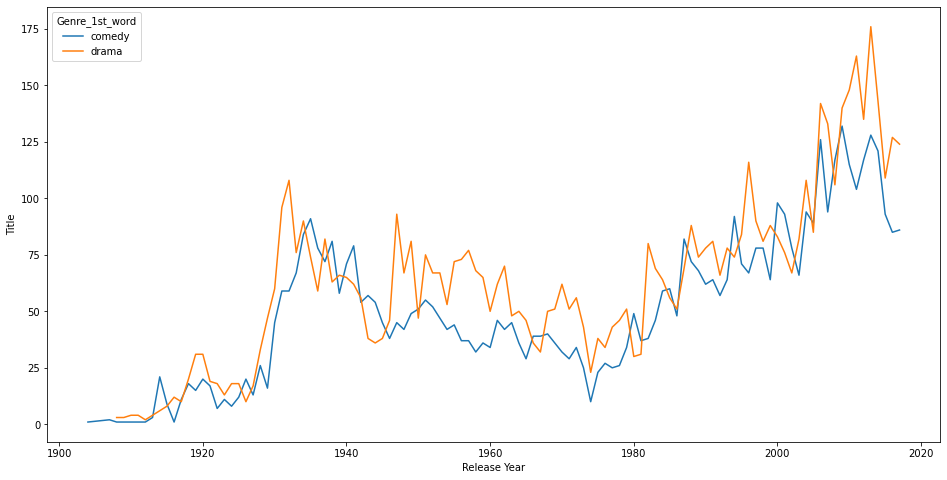

In [73]:
fig, ax = plt.subplots(figsize=(16,8))
sns.lineplot(x=dr_com['Release Year'] , y=dr_com['Title'], hue = dr_com['Genre_1st_word'])